In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import cvxpy as cp

%matplotlib inline

%cd ..

%run bandit_definitions.py
%run algorithms.py
%run sim_utilities.py
%run optim_utils.py

/Users/hedi/Desktop/bandits_lab


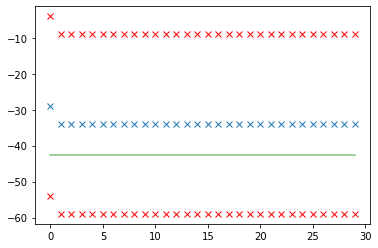

In [3]:
K = 30
T = 10000
np.random.seed(0)


ds = 0.2*np.ones(K)
ds[0] = 0.1
M = 1
scale = 50
mus = M - scale*(1/2 + ds)
band = UnifDBand(K, mus, M, scale)

plt.plot(band.mus, 'x')
plt.plot(np.arange(K), band.mus[0] - 5*scale*np.sqrt(K/T)*np.ones(K), 'g', alpha=0.5)
plt.plot(band.mus + scale / 2, 'rx')
plt.plot(band.mus - scale / 2, 'rx')

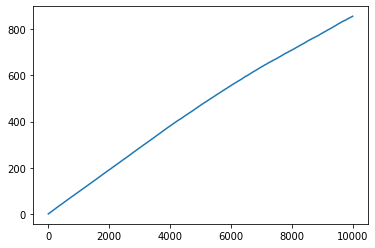

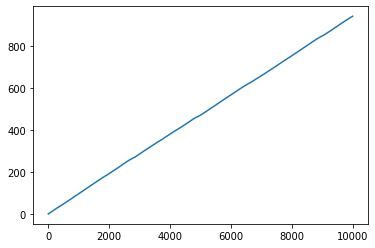

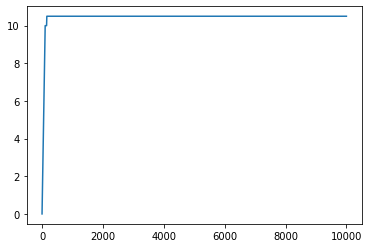

In [93]:
def one_run(alg, band, T):
    np.random.seed(1)

    band.reset()
    alg.reset()
    for _ in range(T):
        alg.play_once(band)
    plt.plot(np.array(band.cum_regret) / scale)
    plt.show()

algs = [
    AdaHedgeExp3Bounded(K, M=M),
    Exp3(K , M=M, label="Vanilla Exp3"),
    UCB(K, sig=1, label="UCB \sigma = true scale ="+str(scale)),
]

for alg in algs:
    one_run(alg, band, T)
    

In [11]:
np.random.seed(0)

Ntest = lambda _ : 5
K = 20
T = 100

ds = 0.2*np.ones(K)
ds[0] = 0.1
M = 1
scales = [0.1, 1, 10]
mus_list = [M - scale*(1/2 + ds) for scale in scales]

band_list = [UnifDBand(K, mus_list[i], M, scale) for i, scale in enumerate(scales)]

alg_list = [
    UCB(K, sig=0.1, label="UCB \sigma = "+str(0.1)),
    UCB(K, sig=1, label="UCB \sigma = 1"),
    UCB(K, sig=scale, label="UCB \sigma = true scale ="+str(scale)),
    UCB(K, sig=200, label="UCB \sigma = 200"),
    #Exp3(K , M=M, label="Vanilla Exp3"),
    AdaHedgeExp3(K, M=M, label="True AdaExp3"),
    #AdaFTRLTsallis(K, M=M, sym=False, proxy=True, label="AdaFTRL Tsallis prox"), 
    #AdaFTRLTsallis(K, M=M, sym=False, label="AdaFTRL Tsallis"), 
    #FTRL_w_reg(K, opt_ut.Tsallis_1_2_sym(K), M=M, label="SymTsallis"),
    #AdaFTRLTsallis(K, M=100, label="AdaHedge Tsallis M={}".format(100)),
    UCB(K, sig=0, label="FTL"),
    RandomPlay(K, label="random play"),
    ]

data_dict={
    'name':'Long Name',
    'short_name':'short_name',
    'T':T,
    'Ntest':Ntest,
    'band_list':band_list,
    'alg_list':alg_list,
    'results':None,
    'scales':scales,
    'seed':0
}

launch(data_dict, fair_reg=False)

UCB \sigma = 0.1  took  0.024754047393798828  total, i.e.,  0.004950809478759766  per run
UCB \sigma = 1  took  0.016211986541748047  total, i.e.,  0.0032423973083496095  per run
UCB \sigma = true scale =50  took  0.026891708374023438  total, i.e.,  0.005378341674804688  per run
UCB \sigma = 200  took  0.0124359130859375  total, i.e.,  0.0024871826171875  per run
True AdaExp3  took  0.08534502983093262  total, i.e.,  0.017069005966186525  per run
FTL  took  0.012332916259765625  total, i.e.,  0.002466583251953125  per run
random play  took  0.00436711311340332  total, i.e.,  0.0008734226226806641  per run
UCB \sigma = 0.1  took  0.012575149536132812  total, i.e.,  0.0025150299072265623  per run
UCB \sigma = 1  took  0.012547016143798828  total, i.e.,  0.002509403228759766  per run
UCB \sigma = true scale =50  took  0.014749765396118164  total, i.e.,  0.002949953079223633  per run
UCB \sigma = 200  took  0.012197732925415039  total, i.e.,  0.002439546585083008  per run
True AdaExp3  too

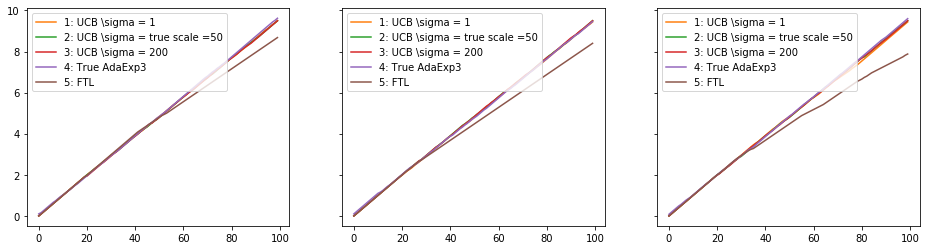

In [9]:
skips = [0, 6]
#t_slice = range(int(1e3), int(1e4))
plot_and_save(data_dict, save_data=False, skip_algs=skips, log_scale=False, show_vars=False,
              rescale=True)#, t_slice=t_slice)

In [45]:
def plot_deltas(alg_list):
    for alg in alg_list:
        if 'mix_gaps' in vars(alg).keys():
            plt.plot([x for x in alg.mix_gaps], label=alg.label)
            plt.legend()
            plt.show()
        if 'true_mix_gaps' in vars(alg).keys():
            plt.plot([x for x in alg.true_mix_gaps], label=alg.label+" True Mix Gaps", alpha=0.3)
            plt.legend()
            plt.show()

def plot_etas(alg_list, normalize=False):
    for alg in alg_list:
        deltas = alg.mix_gaps
        etas = deltas_to_etas(deltas)
        if normalize:
            plt.plot( [1 / np.square(eta) for eta in etas])
            plt.title("1 / etas^2 : "+alg.label)
        else:
            plt.plot(etas)
            plt.title("etas : "+alg.label)
        plt.show()
        
def deltas_to_etas(deltas):
    r = []
    cum = 0
    for i, delta in enumerate(deltas):
        cum += delta
        if cum == 0:
            r.append(1000)
        else:
            r.append(1. / cum)
    return r

#plot_deltas(alg_list[2:])
#plot_etas(alg_list[2:], normalize=True)


In [ ]:
np.random.seed(50)
K = 15

l0 = 1
p = np.random.rand(K) 
p /= np.sum(p)
eta0 = 1

def objective(l, p, K, eta=1, i= 0):
    return eta*np.square(l)*np.power(p[i], -1/2)

ls = np.linspace(0, 5, 100)

print(p)
for i in range(K):
    print(p[i])
    
    true_mixs = [mix_gap_comp(l, p, K, eta=eta0, i=i)[1] for l in ls]
    bound = [objective(l, p, K, eta=eta0, i=i) for l in ls]
    plt.plot(ls, true_mixs , label="true")
    plt.plot(ls, bound, label="bound")
    plt.legend()
    plt.show()
    diff = np.array(bound) - np.array(true_mixs)
    plt.plot(ls,  diff)
    plt.show()
    print("minimum difference :", min(diff))

In [36]:
[c for c in plt.get_cmap('Dark2').colors]

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4)]

In [ ]:
'true_mix_gaps' in vars(alg_list[0]).keys()